<h2>Data Manipulation</h2>

In order to start the data analysis, we will need to import a variety of packages.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

We will read in the data, which was downloaded from the Airbnb website and look at its info.

In [4]:
# Read in data
dat = pd.read_csv('listings.csv')
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6366 non-null   int64  
 1   listing_url                                   6366 non-null   object 
 2   scrape_id                                     6366 non-null   float64
 3   last_scraped                                  6366 non-null   object 
 4   name                                          6366 non-null   object 
 5   description                                   6352 non-null   object 
 6   neighborhood_overview                         4663 non-null   object 
 7   picture_url                                   6366 non-null   object 
 8   host_id                                       6366 non-null   int64  
 9   host_url                                      6366 non-null   o

We can see that there are 74 columns, and 6,366 observations, however some values are missing in various columns.

In [5]:
test = dat['calendar_last_scraped'] == dat['last_scraped']

In [6]:
test.unique()

array([ True])

<h2>Data Cleansing</h2>

<h4>Drop off irrelevant columns:</h4>

* URLs will not be useful
* Empty columns: 'neighborhood_group_cleansed', 'bathrooms', 'calendar_updated'
* 'neighborhood' column only has blank values or 'Chicago, Illinois, United States' value, making it useless
* Drop 'host_listings_count' and 'host_total_listings_count', use the calculated_host_listings columns
* 'scrape_id' is all the same value and not useful for our needs
* 'calendar_last_scraped' can be dropped (same value as 'last_scraped')

In [7]:
dat = dat.drop(['scrape_id','listing_url','host_url','host_thumbnail_url','host_picture_url','picture_url',
               'neighbourhood_group_cleansed','bathrooms','calendar_updated','neighbourhood',
               'calendar_last_scraped','host_listings_count'], axis = 1)

<h4>Bathrooms Column:</h4>

In [8]:
dat['bathrooms_text'].sample(10)

530      1 shared bath
4       1 private bath
221            2 baths
1722     1 shared bath
1749         1.5 baths
2807    1 private bath
1830     1 shared bath
5408            1 bath
1936            1 bath
6349            1 bath
Name: bathrooms_text, dtype: object

Looking at the 'bathrooms_text' column, we see that it is not very usable in its current state.  We will split the bathroom text column into two: one containing a float variable for the number of bathrooms, and the other an additional descriptor of the bathroom (shared/private).

In [9]:
# First let us make all text lowercase to simplify string manipulation
dat['bathrooms_text'] = dat['bathrooms_text'].str.lower()

# Next we must convert any text 'half' to 0.5 so it is included in the subsequent number extraction
dat['bathrooms_text'] = dat['bathrooms_text'].str.replace(r'(half)+','0.5', regex = True)

# Then extract the numbers into the new 'bathrooms' float32 data type column
dat['bathrooms'] = dat['bathrooms_text'].str.extract(r'(\d+\.?\d*)', expand = True).astype(np.float32)

# This leaves us with only float and NaN values
dat['bathrooms'].unique()

array([ 1. ,  2. ,  1.5,  3. ,  2.5,  0. ,  3.5, 11. ,  5. ,  nan,  0.5,
        4. ,  4.5, 11.5,  6.5,  7. ,  5.5,  6. ,  8. , 12.5, 10. ],
      dtype=float32)

Above are the unique values left for the float variable in the column 'bathrooms'.

<h4>Bathrooms Text Column:</h4>

In [10]:
# Remove the text 'bath', unnecessary symbols and whitespace, then extract the leftover text

dat['bathrooms_text'] = dat['bathrooms_text'].str.replace(r'(bath)s*|(Bath)s*','', regex = True)
dat['bathrooms_text'] = dat['bathrooms_text'].str.replace(r' +|\.+|\-+','', regex = True)
dat['bathrooms_text'] = dat['bathrooms_text'].str.extract(r'(\D+)')
dat['bathrooms_text'].count()

1587

In [11]:
dat['bathrooms_text'].unique()

array(['shared', nan, 'private'], dtype=object)

This leaves us with only 1,587 observations with one of the bathroom descriptors, 'shared' or 'private'; the rest are missing values since the original data did not contain text for them.

<h4>DateTime Columns:</h4>

Next, let's convert the datetime columns into the proper datatype.

In [12]:
# Convert dates to datetime data type

dat['host_since'] = pd.to_datetime(dat['host_since'])
dat['first_review'] = pd.to_datetime(dat['first_review'])
dat['last_review'] = pd.to_datetime(dat['last_review'])

<h4>Rate Columns:</h4>

In [13]:
dat['host_response_rate'].sample(5)

3034    100%
2751     NaN
1152     NaN
3145     NaN
925      95%
Name: host_response_rate, dtype: object

We can see that we will need to convert the percentage columns ('host_response_rate' and 'host_acceptance_rate') into float variables.

In [14]:
# Convert host response rate and acceptance rate columns into float

dat['host_response_rate'] = dat['host_response_rate'].str.replace(r'(\D)','', regex = True).astype(np.float32)/100
dat['host_acceptance_rate'] = dat['host_acceptance_rate'].str.replace(r'(\D)','', regex = True).astype(np.float32)/100
dat['host_response_rate'].sample(5)

5978    0.29
6250    1.00
4100    1.00
4469    1.00
3568    1.00
Name: host_response_rate, dtype: float32

<h4>Boolean Columns:</h4>

In [15]:
dat['host_is_superhost'].unique()

array(['t', 'f', nan], dtype=object)

We will convert the 't' and 'f' values to binary float values for later analysis, where 1 will mean "True".

In [16]:
# Map superhost column to boolean values

dat['host_is_superhost'] = dat['host_is_superhost'].map({'t':1,'f':0}).astype('float')
dat['host_has_profile_pic'] = dat['host_has_profile_pic'].map({'t':1,'f':0}).astype('float')
dat['host_identity_verified'] = dat['host_identity_verified'].map({'t':1,'f':0}).astype('float')
dat['has_availability'] = dat['has_availability'].map({'t':1,'f':0}).astype('float')
dat['instant_bookable'] = dat['instant_bookable'].map({'t':1,'f':0}).astype('float')

In [17]:
dat['host_is_superhost'].unique()

array([ 1.,  0., nan])

<h4>Price Column:</h4>

Convert the price column to a float data type.

In [18]:
dat['price'] = dat['price'].str.extract(r'(\d+\.\d+)').astype(np.float64)

In [19]:
dat['price'].sample(5)

1604     60.0
5062     50.0
771     151.0
5620    494.0
5324    176.0
Name: price, dtype: float64

In [20]:
dat['license'].sample(20)

3551                 R19000046222
1394                 R19000045801
3467                 R20000052930
6311                 R19000042634
5444                 R21000060727
2409    City registration pending
2119                 R18000026601
382                  R18000036959
1445    City registration pending
3047                 R19000041313
1753    City registration pending
4123                 R20000051972
2607                 R20000060001
5930       Hotel License #2780536
3532    City registration pending
4967                   Registered
1339    City registration pending
97                        2262746
3273    City registration pending
890                  R17000019509
Name: license, dtype: object

It does not seem that the license column will be useful so we will drop it from the dataset.

In [21]:
dat = dat.drop(['license'], axis=1)

<h2>Data Exploration and Visualization</h2>

Let us explore the data in the dataset.

<h4>Unique Hosts</h4>

First, how many unique hosts are there?

In [22]:
dat['host_id'].nunique()

3371

In [23]:
listings_by_host = dat['host_id'].value_counts()
listings_by_host.describe()

count    3371.000000
mean        1.888460
std         5.548921
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       260.000000
Name: host_id, dtype: float64

In [24]:
listings_by_host[listings_by_host > 1].count()

799

Here we can see that out of the 3,371 unique hosts, 799 have more than one listing in the Chicago area.  Interestingly, there is one host id with 260 listings.

Let's graph this data to see the distribution of hosts with differing numbers of listings.

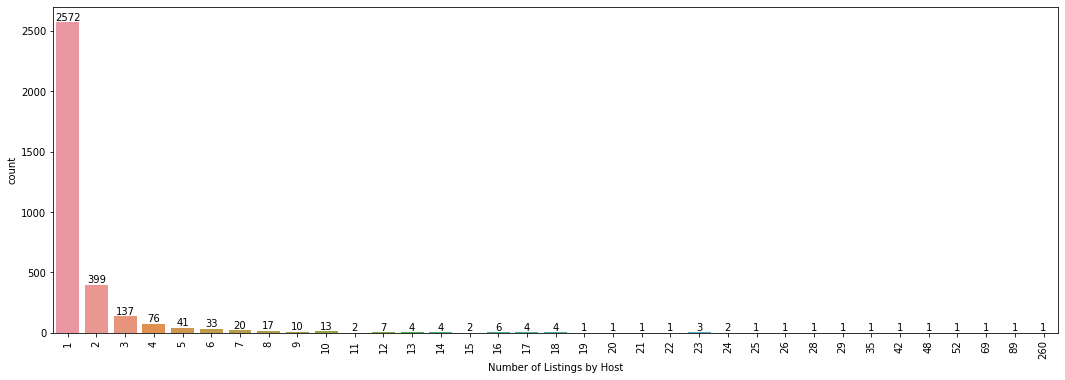

In [25]:
plt.figure(figsize=(18,6))
p = sb.countplot(x=listings_by_host, order=sorted(listings_by_host.unique()))
p.set_xticklabels(labels=p.get_xticklabels(),rotation=90)
p.bar_label(p.containers[0])
plt.xlabel('Number of Listings by Host')
plt.show()

It is obvious that a vast majority of hosts have only one listing in the Chicago area.

<h4>Host Response Time</h4>


In [26]:
dat['host_response_time'].unique()

array(['within an hour', 'within a few hours', nan, 'within a day',
       'a few days or more'], dtype=object)

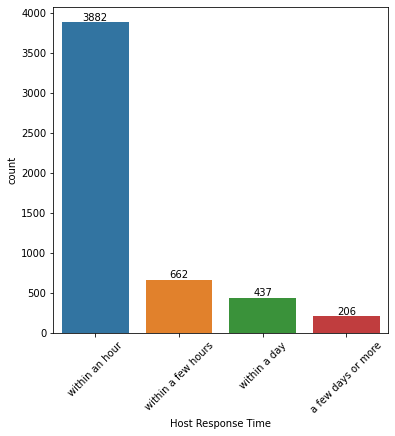

In [27]:
plt.figure(figsize=(6,6))
p = sb.countplot(x='host_response_time',data = dat)
p.set_xticklabels(labels=p.get_xticklabels(),rotation=45)
p.bar_label(p.containers[0])
plt.xlabel('Host Response Time')
plt.show()

Here we can see there are four categories for the response time.  Let's define a system for rating the response time by using floating numbers.  We will assign the values in hours and as follows:
 * 'within an hour' = 1 hour
 * 'within a few hours' = 5 hours
 * 'within a day' = 24 hours
 * 'a few days or more' = 48 hours

In [28]:
dat['host_response_time_float'] = dat['host_response_time'].map({'within an hour':1,'within a few hours':5,
                                                           'within a day':24,'a few days or more':48}).astype(np.float32)
dat['host_response_time_float'].unique()

array([ 1.,  5., nan, 24., 48.], dtype=float32)

<h4>Host Verifications</h4>

In order to simplify future analysis, let us count the number of verifications the host has and list this in a new column.

In [29]:
dat['host_verifications'].sample(5)

2950    ['email', 'phone', 'reviews', 'offline_governm...
6363                                   ['email', 'phone']
2266    ['email', 'phone', 'reviews', 'offline_governm...
1397    ['email', 'phone', 'reviews', 'jumio', 'offlin...
1951    ['email', 'phone', 'facebook', 'reviews', 'jum...
Name: host_verifications, dtype: object

We can see that the verifications are separated by a comma, so we will use this to count the number of verifications each host has.

In [30]:
dat['no_of_verif'] = dat['host_verifications'].str.count(r',') + 1
dat.loc[:, ['host_verifications','no_of_verif']].head()

,host_verifications,no_of_verif
0,"['email', 'phone', 'reviews', 'manual_offline'...",6
1,"['email', 'phone', 'reviews', 'jumio', 'offlin...",8
2,"['email', 'phone', 'reviews', 'jumio', 'govern...",6
3,"['email', 'phone', 'reviews', 'offline_governm...",7
4,"['email', 'phone', 'facebook', 'reviews', 'kba']",5


In order to catch any observations where hosts have no verifications, we will set the number of verifications to zero where the host_verifications = 'None'.  This is important since the code above would have counted 'none' and an observation without a comma (i.e. only one verification) as 1.

In [31]:
dat['no_of_verif'] = np.where(dat['host_verifications'] == 'None', 0, dat['no_of_verif'])

In [32]:
dat['no_of_verif'].describe()

count    6366.000000
mean        5.585768
std         2.313344
min         0.000000
25%         4.000000
50%         6.000000
75%         7.000000
max        12.000000
Name: no_of_verif, dtype: float64

On average, hosts have about 5-6 different identity verifications. 

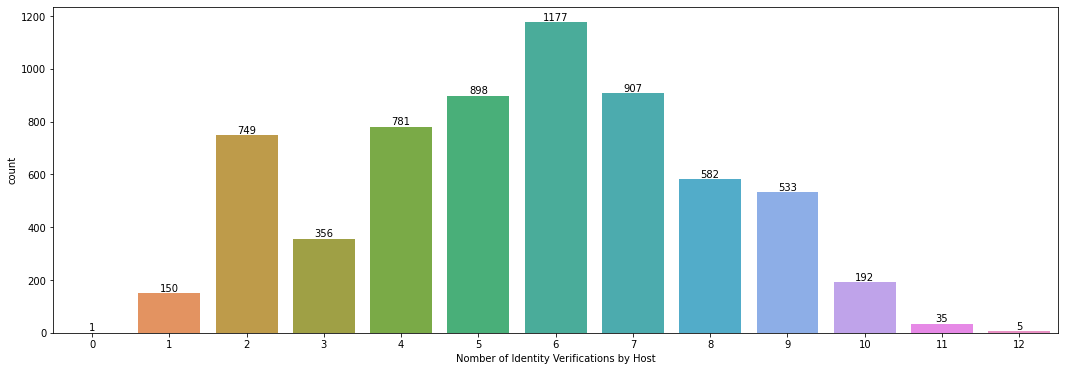

In [33]:
plt.figure(figsize=(18,6))
p = sb.countplot(x='no_of_verif',data = dat)
p.bar_label(p.containers[0])
plt.xlabel('Nomber of Identity Verifications by Host')
plt.show()

<h4>Amenities</h4>

Repeat the same process for number of amenities listed.

In [34]:
dat['no_of_amen'] = dat['amenities'].str.count(r',') + 1
dat.loc[:, ['amenities','no_of_amen']].head()

,amenities,no_of_amen
0,"[""Hot water kettle"", ""Wine glasses"", ""Kitchen""...",51
1,"[""Kitchen"", ""Free street parking"", ""Long term ...",30
2,"[""Kitchen"", ""Free street parking"", ""Shampoo"", ...",33
3,"[""Kitchen"", ""Long term stays allowed"", ""Smoke ...",31
4,"[""Free street parking"", ""Shampoo"", ""Smoke alar...",22


In [35]:
dat['no_of_amen'].describe()

count    6366.000000
mean       31.138549
std        10.615332
min         1.000000
25%        24.000000
50%        31.000000
75%        37.000000
max        82.000000
Name: no_of_amen, dtype: float64

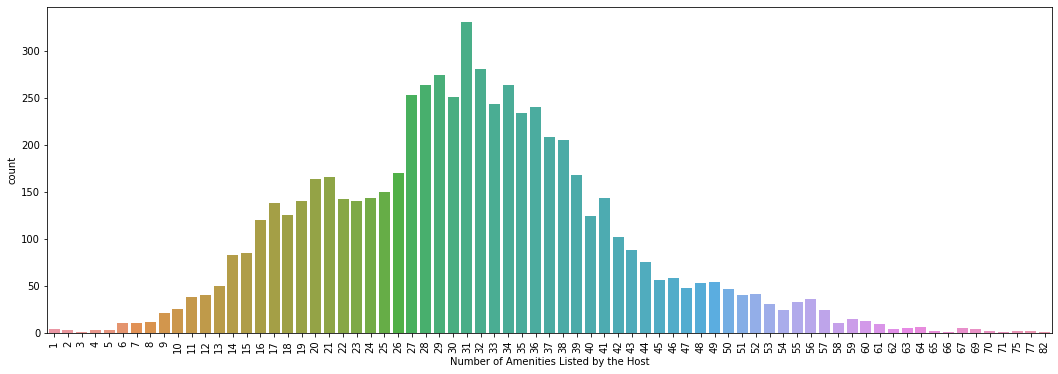

In [36]:
plt.figure(figsize=(18,6))
p = sb.countplot(x='no_of_amen',data = dat)
p.set_xticklabels(labels=p.get_xticklabels(),rotation=90)
plt.xlabel('Number of Amenities Listed by the Host')
plt.show()

<h4>Distance from Center of Chicago</h4>

Let's calculate the distance of the listing from the center of the city of Chicago.  We will use the following coordinates: 41.8781° N, 87.6298° W (source needed?).

We will use the Haversine formula to calculate the distance in miles.  In order to do so, we will first define a function to perform the calculation.

In [37]:
# Coordinates for center of Chicago in degrees
lat1 = 41.8781
long1 = -87.6298

# Constant, radius of the Earth in miles
r = 3958.8

# Define a function to calculate the distance
def haversine(lat2, long2):
    # First convert degrees into radians:
    rlat1 = lat1 * (math.pi / 180)
    rlat2 = lat2 * (math.pi / 180)
    rlong1 = long1 * (math.pi / 180)
    rlong2 = long2 * (math.pi / 180)
    
    # Calculate the differnce between the latitudes and longitudes
    dlat = rlat1 - rlat2
    dlong = rlong1 - rlong2
    
    # Use the Haversine formula (broken into 3 terms for simplification here)
    a = (math.sin(dlat / 2) ** 2)         # First term
    b = math.cos(rlat1) * math.cos(rlat2) # Second term
    c = (math.sin(dlong / 2) ** 2)        # Third term
    e = math.sqrt(a + b * c)
    d = 2 * r * e                         # where r is the radius of the Earth
    return d

Then, apply the formula to each observation in the data set, returning the answer in a new column for the distance from the center of the city.

In [38]:
dat['d_center'] = dat.apply(
    lambda row: haversine(row['latitude'], row['longitude']),
    axis=1)
dat['d_center'].sample(5)

1899    6.523089
5041    6.891157
3869    2.767134
1385    6.885432
1415    4.699820
Name: d_center, dtype: float64

In [39]:
dat['d_center'].describe()

count    6366.000000
mean        4.319250
std         2.726591
min         0.010381
25%         2.007158
50%         4.003650
75%         6.028991
max        16.372642
Name: d_center, dtype: float64

In order to visualize the distances, let us plot them against the listing price values.

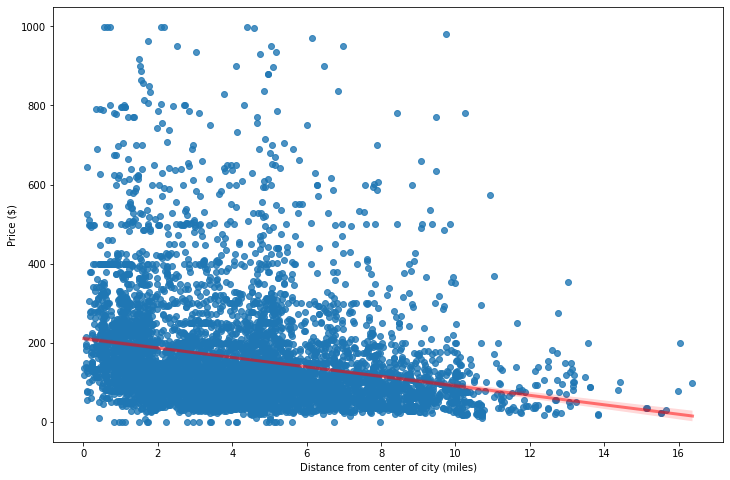

In [40]:
plt.figure(figsize=(12,8))
sb.regplot(x="d_center", y="price", 
            line_kws={"color":"r","alpha":0.5,"lw":3}, data=dat)
plt.xlabel('Distance from center of city (miles)')
plt.ylabel('Price ($)')
plt.show()

On first look, it appears that the listings further from the city are less valuable on average.

<h4>Property and Room Types</h4>

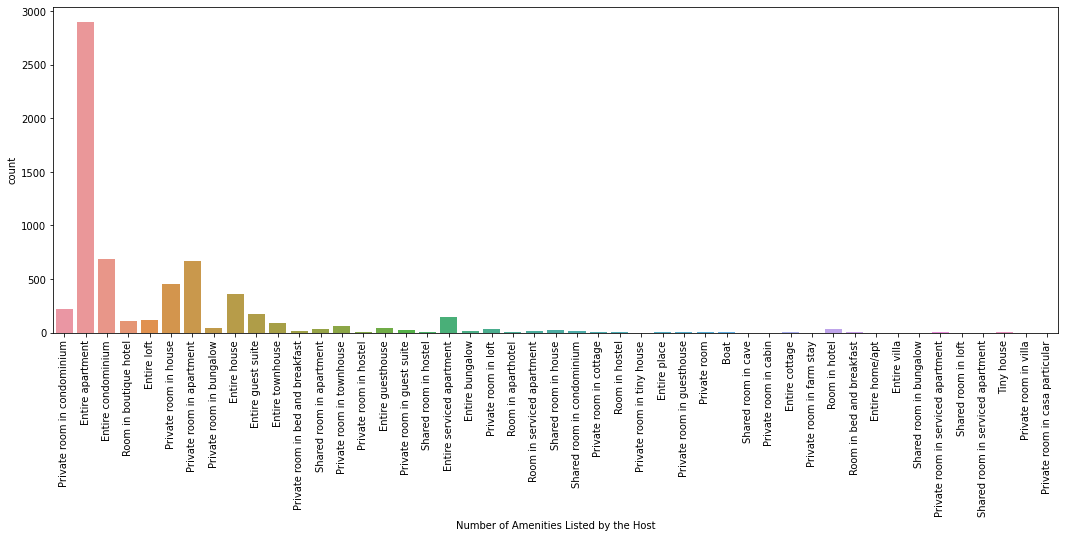

In [41]:
plt.figure(figsize=(18,6))
p = sb.countplot(x='property_type',data = dat)
p.set_xticklabels(labels=p.get_xticklabels(),rotation=90)
plt.xlabel('Number of Amenities Listed by the Host')
plt.show()

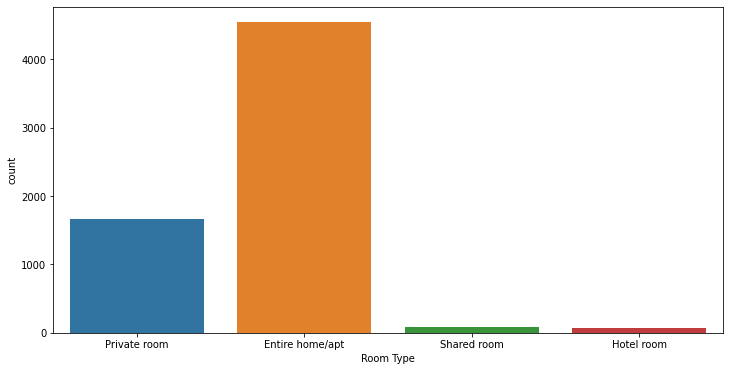

In [57]:
plt.figure(figsize=(12,6))
p = sb.countplot(x='room_type',data = dat)
plt.xlabel('Room Type')
plt.show()

<h2>Dimension Reduction</h2>



In [43]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 66 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            6366 non-null   int64         
 1   last_scraped                                  6366 non-null   object        
 2   name                                          6366 non-null   object        
 3   description                                   6352 non-null   object        
 4   neighborhood_overview                         4663 non-null   object        
 5   host_id                                       6366 non-null   int64         
 6   host_name                                     6365 non-null   object        
 7   host_since                                    6365 non-null   datetime64[ns]
 8   host_location                                 6355 non-null   object

In order to complete a Principal Component Analysis, we need to only select the numeric values and drop values with NaNs.

In [47]:
# Select only numeric values
dat_pre_norm = dat.loc[:,['host_response_rate','host_acceptance_rate','host_is_superhost',
                         'host_total_listings_count','host_has_profile_pic',
                          'host_identity_verified','latitude','longitude','accommodates','bedrooms','beds',
                         'price','minimum_minimum_nights','maximum_minimum_nights',
                         'minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
                         'maximum_nights_avg_ntm','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d',
                         'review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                         'review_scores_checkin','review_scores_communication','review_scores_location',
                         'review_scores_value','reviews_per_month']]
dat_pre_norm = dat_pre_norm.dropna()

In [48]:
dat_norm = scale(dat_pre_norm)

For the fist PCA, we will include all of the variables (i.e. columns from the selection above).

In [49]:
pca1 = PCA(n_components=len(dat_pre_norm.columns))

pca1.fit(dat_norm)

PCA(n_components=29)

In [50]:
var = pca1.explained_variance_ratio_
var1 = np.cumsum(np.round(pca1.explained_variance_ratio_, decimals=4)*100)
print(var1)

[ 18.94  30.52  41.58  51.62  59.7   64.85  69.41  73.03  76.36  79.51
  82.27  84.77  87.15  89.25  91.06  92.72  94.24  95.33  96.28  97.09
  97.81  98.44  99.02  99.56  99.92 100.   100.   100.   100.  ]


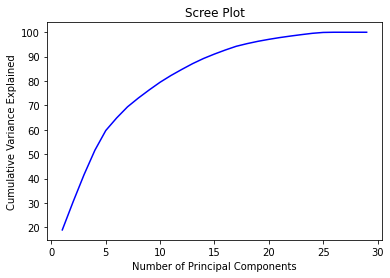

In [51]:
var1 = pd.DataFrame(var1, index=np.arange(1,int(len(dat_pre_norm.columns))+1))
plt.plot(var1,color='blue')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.show()

Taking the first 18 principal components will correspond to 90% of the variance explained.

In [52]:
pca18 = PCA(n_components=18)
pca18.fit(dat_norm)
data_pca18 = pca18.transform(dat_norm)

# Convert the numpy array to pandas DataFrame
data_pca18 = pd.DataFrame(data_pca18)
data_pca18.columns = ["PC"+str(i) for i in range(1,19)]

In [53]:
data_pca18.corr()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
PC1,1.000000e+00,-1.766753e-16,-2.067355e-17,-2.908122e-16,9.983482e-19,1.667827e-16,2.250690e-16,-1.062138e-16,-2.227367e-16,-7.737609e-17,-1.750562e-16,1.541958e-16,4.398101e-17,2.957996e-17,2.746828e-16,8.252890e-17,-3.382917e-17,2.070143e-17
PC2,-1.766753e-16,1.000000e+00,-1.233392e-15,2.133117e-16,1.600211e-16,8.643205e-16,-8.437016e-17,-3.956971e-16,-2.524045e-16,-3.471686e-16,1.563393e-16,1.988135e-16,1.176741e-16,-2.789326e-16,-6.655669e-17,8.040493e-17,3.085346e-16,2.601271e-16
PC3,-2.067355e-17,-1.233392e-15,1.000000e+00,1.601691e-16,3.085074e-16,2.752455e-16,1.276838e-16,-3.158037e-16,2.629095e-18,3.912861e-17,1.663050e-16,7.141456e-17,-2.550861e-16,-1.660130e-16,-1.411149e-16,1.339975e-16,1.202289e-16,1.694321e-16
PC4,-2.908122e-16,2.133117e-16,1.601691e-16,1.000000e+00,-3.451497e-16,4.396407e-16,1.072416e-16,-7.339125e-16,-7.427931e-17,6.298959e-17,7.137839e-16,-2.446055e-16,-2.518594e-16,-1.791569e-17,7.025128e-18,-1.789170e-16,-3.131850e-16,-5.443680e-18
PC5,9.983482e-19,1.600211e-16,3.085074e-16,-3.451497e-16,1.000000e+00,3.115162e-16,6.622006e-17,4.639082e-18,-3.312033e-16,-1.830468e-16,7.714658e-16,1.398378e-16,1.884973e-16,-1.189518e-16,-1.441448e-16,9.467595e-17,1.963092e-16,1.141440e-16
PC6,1.667827e-16,8.643205e-16,2.752455e-16,4.396407e-16,3.115162e-16,1.000000e+00,-3.422648e-16,-1.399280e-15,-3.138080e-16,8.370413e-17,-6.712424e-17,4.997190e-16,-3.375793e-17,-3.829462e-16,-1.029608e-16,6.569757e-16,-5.082794e-17,3.618022e-16
PC7,2.250690e-16,-8.437016e-17,1.276838e-16,1.072416e-16,6.622006e-17,-3.422648e-16,1.000000e+00,-5.021384e-17,-1.819120e-16,-2.695306e-16,-7.661339e-17,3.166290e-17,2.725025e-17,-4.415881e-16,-4.506193e-17,-2.957832e-16,2.956142e-17,-1.836188e-16
PC8,-1.062138e-16,-3.956971e-16,-3.158037e-16,-7.339125e-16,4.639082e-18,-1.399280e-15,-5.021384e-17,1.000000e+00,6.665492e-17,2.999660e-16,-9.875549e-17,1.238105e-16,-2.151663e-16,-2.140879e-16,2.084979e-17,1.860542e-16,-1.817381e-16,4.762468e-18
PC9,-2.227367e-16,-2.524045e-16,2.629095e-18,-7.427931e-17,-3.312033e-16,-3.138080e-16,-1.819120e-16,6.665492e-17,1.000000e+00,-2.000714e-16,-1.963385e-16,7.239591e-17,4.329682e-16,3.303994e-16,-8.821699e-17,-2.367714e-17,-1.313792e-16,8.922029e-17
PC10,-7.737609e-17,-3.471686e-16,3.912861e-17,6.298959e-17,-1.830468e-16,8.370413e-17,-2.695306e-16,2.999660e-16,-2.000714e-16,1.000000e+00,-2.525183e-16,5.993731e-16,-2.637974e-16,-2.978498e-16,4.015807e-17,1.105142e-16,-1.616538e-16,-1.056875e-16


From the above correlation table, we can find that the pairwise correlations between two components are close to zeros. This means that all these components are orthogonal (not correlated). There is no multicollinearity among principal components.